# Zillow Clustering Project

#### Robert Murphy

#### June 22 2021
_________________________________

------------------------------------

# Imports:

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from scipy import stats

from matplotlib import cm
import seaborn as sns
from sklearn.model_selection import learning_curve
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LassoLars
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import TweedieRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
import viz_kmeans

# default pandas decimal number display format
pd.options.display.float_format = '{:20,.2f}'.format
# supress scientific notation
np.set_printoptions(suppress=True)

from sklearn.cluster import KMeans
import acquire
import explore
import zillow_wrangle
import prepare

In [2]:
# using a function which contains a implmentied sql query to bring in th dataset.
zillow_df = acquire.get_zillow_cached()
zillow_df= zillow_df.loc[:, ~zillow_df.columns.duplicated()]

zillow_df.head(1)

,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,...,censustractandblock,logerror,transactiondate,propertylandusedesc,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,storydesc,typeconstructiondesc
0,1727539,14297519,nan,nan,nan,3.50,4.00,None,nan,3.50,...,"60,590,630,072,012.00",0.03,2017-01-01,Single Family Residential,None,None,None,None,None,None


In [3]:
zillow_df.set_index('parcelid', inplace = True)

In [4]:
# 52,968 records x 67 fields
zillow_df.shape

(52953, 67)

In [5]:
zillow_df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,"52,953.00","1,497,097.55","859,452.25",349.00,"757,502.00","1,500,314.00","2,241,055.00","2,982,270.00"
airconditioningtypeid,"13,650.00",2.44,3.84,1.00,1.00,1.00,1.00,13.00
architecturalstyletypeid,70.00,7.10,2.67,2.00,7.00,7.00,7.00,21.00
basementsqft,50.00,679.72,689.70,38.00,273.00,515.00,796.50,"3,560.00"
bathroomcnt,"52,953.00",2.29,1.02,0.00,2.00,2.00,3.00,18.00
bedroomcnt,"52,953.00",3.29,0.96,0.00,3.00,3.00,4.00,14.00
buildingqualitytypeid,"33,807.00",6.27,1.72,1.00,5.00,6.00,8.00,12.00
calculatedbathnbr,"52,748.00",2.30,1.02,1.00,2.00,2.00,3.00,18.00
decktypeid,415.00,66.00,0.00,66.00,66.00,66.00,66.00,66.00
finishedfloor1squarefeet,"4,724.00","1,508.89",670.26,66.00,"1,112.00","1,383.00","1,718.00","6,912.00"


In [6]:
# looking into duplicates and missing values
# right away there is several columns which contain a high number of missing values.
#  
prepare.miss_dup_values(zillow_df)

Your selected dataframe has 67 columns.
There are 52 columns that have missing values.
  
** There are 0 duplicate rows that represents 0.0% of total Values**


,Missing Values,% of Total Values
buildingclasstypeid,52953,100.00
buildingclassdesc,52953,100.00
finishedsquarefeet15,52953,100.00
finishedsquarefeet13,52911,99.90
basementsqft,52903,99.90
storydesc,52903,99.90
storytypeid,52903,99.90
yardbuildingsqft26,52888,99.90
architecturalstyletypeid,52883,99.90
architecturalstyledesc,52883,99.90


In [7]:
prepare.summarize(zillow_df)

Dataframe head: 
               id  airconditioningtypeid  architecturalstyletypeid  \
parcelid                                                             
14297519  1727539                    nan                       nan   
17052889  1387261                    nan                       nan   
14186244    11677                    nan                       nan   
12177905  2288172                    nan                       nan   
12095076   781532                   1.00                       nan   
12069064   870991                    nan                       nan   
12790562  1246926                    nan                       nan   
11104527  1639362                   1.00                       nan   
13944538   249412                  13.00                       nan   
17110996    43675                    nan                       nan   

                 basementsqft          bathroomcnt           bedroomcnt  \
parcelid                                                           

---------------------

### Main Takeaways:

- Utilized a function which contains sql query to bring in dataset.
- Right away can see several columns which are missing several values over 50%. It might be ideal to just drop these columns.
- Will probably just keep columns which contain 90% non null values.
- Three datatypes; integer, float and object. 
- Some of the fields can be changed to a categorical utilizing 0 and 1.

--------------


# Prepare:

In [8]:
### No need to drop duplicates since there currently is none.###

In [9]:
# utilizing function which drops columns and rows that do not contain <90% non null values.
# this resulted in the shape ofd the df being 52801 records x 28 fields
zillow_check = prepare.handle_missing_values(zillow_df)
zillow_df = prepare.handle_missing_values(zillow_df)
zillow_check.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52801 entries, 14297519 to 12826780
Data columns (total 28 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            52801 non-null  int64  
 1   bathroomcnt                   52801 non-null  float64
 2   bedroomcnt                    52801 non-null  float64
 3   calculatedbathnbr             52731 non-null  float64
 4   calculatedfinishedsquarefeet  52794 non-null  float64
 5   finishedsquarefeet12          52597 non-null  float64
 6   fips                          52801 non-null  float64
 7   fullbathcnt                   52731 non-null  float64
 8   latitude                      52801 non-null  float64
 9   longitude                     52801 non-null  float64
 10  lotsizesquarefeet             52423 non-null  float64
 11  propertycountylandusecode     52801 non-null  object 
 12  propertylandusetypeid         52801 non-null  floa

In [10]:
#dropping nan values
zillow_df.dropna(inplace = True )

In [11]:
# shape of dataframe is now 51059 records, 28 fields
zillow_df.shape

(51059, 28)

In [12]:
#To Do:
#Drops: propertylandusedesc,censustractandblock, assessmentyear,id, regionidcity
#Renames:  finishedsquarefeet12 rename to finished living area. Change fips to the county names. 
# Create columns for age of the house and drop year built.

In [13]:
zillow_df = prepare.remove_columns(zillow_df,['propertylandusedesc','censustractandblock','propertycountylandusecode', 'rawcensustractandblock', 'assessmentyear','id', 'regionidcity', 'roomcnt','propertylandusetypeid','calculatedbathnbr'])

In [14]:
zillow_df.columns

Index(['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet',
       'finishedsquarefeet12', 'fips', 'fullbathcnt', 'latitude', 'longitude',
       'lotsizesquarefeet', 'regionidcounty', 'regionidzip', 'yearbuilt',
       'structuretaxvaluedollarcnt', 'taxvaluedollarcnt',
       'landtaxvaluedollarcnt', 'taxamount', 'logerror', 'transactiondate'],
      dtype='object')

In [15]:
# renaming two columns
zillow_df.rename(columns = {'finishedsquarefeet12':'finished_living_area', 'calculatedfinishedsquarefeet':'total_square_ft'}, inplace = True)

def get_counties(df):
    '''
    This function will create dummy variables out of the original fips column. 
    And return a dataframe with all of the original columns except regionidcounty.
    We will keep fips column for data validation after making changes. 
    New columns added will be 'LA', 'Orange', and 'Ventura' which are boolean 
    The fips ids are renamed to be the name of the county each represents. 
    '''
    # create dummy vars of fips id
    county_df = pd.get_dummies(df.fips)
    # rename columns by actual county name
    county_df.columns = ['LA', 'Orange', 'Ventura']
    # concatenate the dataframe with the 3 county columns to the original dataframe
    df_dummies = pd.concat([df, county_df], axis = 1)
    # drop regionidcounty and fips columns
    df_dummies = df_dummies.drop(columns = ['regionidcounty'])
    return df_dummies

get_counties(zillow_df)

In [16]:
zillow_df.head(1).T

parcelid,14297519
bathroomcnt,3.50
bedroomcnt,4.00
total_square_ft,"3,100.00"
finished_living_area,"3,100.00"
fips,"6,059.00"
fullbathcnt,3.00
latitude,"33,634,931.00"
longitude,"-117,869,207.00"
lotsizesquarefeet,"4,506.00"
regionidcounty,"1,286.00"


In [17]:
# change fips to counties, create new columns for age (2017-yearbuilt), can change sqft to acerage

# create taxrate variable
zillow_df['taxrate'] = zillow_df.taxamount/zillow_df.taxvaluedollarcnt*100
# create acreage variable
zillow_df['acres'] = zillow_df.lotsizesquarefeet/43560
zillow_df['structure_dollar_per_sqft'] = zillow_df.structuretaxvaluedollarcnt/zillow_df.total_square_ft
zillow_df['land_dollar_per_sqft'] = zillow_df.landtaxvaluedollarcnt/zillow_df.lotsizesquarefeet
zillow_df['county_name'] = zillow_df['fips'].map({6037:'Los_Angeles', 6059:'Orange', 6111:'Ventura'})
zillow_df['house_age'] = (2017-zillow_df.yearbuilt)

                               
                               


In [18]:
zillow_df.head()

,bathroomcnt,bedroomcnt,total_square_ft,finished_living_area,fips,fullbathcnt,latitude,longitude,lotsizesquarefeet,regionidcounty,...,landtaxvaluedollarcnt,taxamount,logerror,transactiondate,taxrate,acres,structure_dollar_per_sqft,land_dollar_per_sqft,county_name,house_age
parcelid,,,,,,,,,,,,,,,,,,,,,
14297519,3.50,4.00,"3,100.00","3,100.00","6,059.00",3.00,"33,634,931.00","-117,869,207.00","4,506.00","1,286.00",...,"537,569.00","11,013.72",0.03,2017-01-01,1.08,0.10,156.68,119.30,Orange,19.00
17052889,1.00,2.00,"1,465.00","1,465.00","6,111.00",1.00,"34,449,266.00","-119,281,531.00","12,647.00","2,061.00",...,"376,000.00","5,672.48",0.06,2017-01-01,1.22,0.29,60.07,29.73,Ventura,50.00
14186244,2.00,3.00,"1,243.00","1,243.00","6,059.00",2.00,"33,886,168.00","-117,823,170.00","8,432.00","1,286.00",...,"479,489.00","6,488.30",0.01,2017-01-01,1.15,0.19,68.62,56.87,Orange,55.00
12177905,3.00,4.00,"2,376.00","2,376.00","6,037.00",3.00,"34,245,180.00","-118,240,722.00","13,038.00","3,101.00",...,"36,225.00","1,777.51",-0.10,2017-01-01,1.22,0.30,45.84,2.78,Los_Angeles,47.00
12095076,3.00,4.00,"2,962.00","2,962.00","6,037.00",3.00,"34,145,202.00","-118,179,824.00","63,000.00","3,101.00",...,"496,619.00","9,516.26",-0.00,2017-01-01,1.23,1.45,93.41,7.88,Los_Angeles,67.00


In [19]:
#dropping columns
zillow_df.drop(columns = ['regionidzip', 'fips', 'fullbathcnt','transactiondate','regionidcounty','yearbuilt', 'regionidzip','finished_living_area','taxvaluedollarcnt'], inplace = True)

In [20]:
# now to change data types so as to exclude cents and additional inches included within float values.
cols = ['total_square_ft',
        'lotsizesquarefeet',
       'structuretaxvaluedollarcnt',
       'landtaxvaluedollarcnt','structure_dollar_per_sqft','land_dollar_per_sqft']

In [21]:
#conversion function
def df_columns_to_datatype(df, column_list, dtype):
    df[column_list] = df[column_list].astype(dtype)

In [22]:
#dataframe shape after drops
zillow_df.shape

(51059, 16)

In [23]:
zillow_df['acres_bin'] = pd.cut(zillow_df.acres, bins = [0, .10, .15, .25, .5, 1, 5, 10, 20, 50, 200], labels = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9])
zillow_df['sqft_bin'] = pd.cut(zillow_df.total_square_ft, bins = [0, 800, 1000, 1250, 1500, 2000, 2500, 3000, 4000, 7000, 12000], labels = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9])

In [24]:
#changing specified cols to integers.
df_columns_to_datatype(zillow_df, cols, 'int')

In [25]:
zillow_df.dropna(inplace = True)

In [26]:
train, validate, test = prepare.split_continuous(zillow_df)

train -> (28588, 18)
validate -> (12252, 18)
test -> (10211, 18)


### Main Takeaways:
- Removed Nan values and dropped columns with <90% non null values. Resulted in the shape of DF becoming 
- Created dummies on Los, ventura and orange county.
- Dropped 8 columns,  and created 5 additional features.
- Shape of DF 51059 records, 24 fields.
- Created train, validate, and test datasets.


------------------

# Explore:

In [27]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
bathroomcnt,"28,588.00",2.29,1.00,1.00,2.00,2.00,3.00,11.00
bedroomcnt,"28,588.00",3.30,0.93,0.00,3.00,3.00,4.00,10.00
total_square_ft,"28,588.00","1,904.88",961.84,152.00,"1,266.00","1,648.00","2,289.00","11,704.00"
latitude,"28,588.00","34,023,761.80","271,964.29","33,341,224.00","33,831,713.50","34,028,025.00","34,187,465.00","34,818,767.00"
longitude,"28,588.00","-118,199,652.80","361,378.32","-119,475,265.00","-118,399,262.75","-118,157,423.50","-117,930,674.50","-117,572,338.00"
lotsizesquarefeet,"28,588.00","11,519.60","104,954.18",236.00,"5,504.00","6,790.00","8,710.00","6,971,010.00"
structuretaxvaluedollarcnt,"28,588.00","191,885.50","233,676.05",302.00,"77,243.75","130,799.50","221,325.75","7,507,773.00"
landtaxvaluedollarcnt,"28,588.00","324,291.95","490,265.27","3,080.00","73,590.50","214,968.00","405,963.25","19,269,445.00"
taxamount,"28,588.00","6,275.82","7,784.67",61.82,"2,622.16","4,577.47","7,274.44","290,998.06"
logerror,"28,588.00",0.02,0.17,-4.45,-0.02,0.01,0.04,3.18


In [28]:
cols = zillow_df.drop(columns = 'county_name')
cols = cols.columns

In [29]:
# Start with looking into Outliers:
prepare.show_outliers(zillow_df,1.5,cols)

For bathroomcnt the lower bound is 0.5 and  upper bound is 4.5
For bedroomcnt the lower bound is 1.5 and  upper bound is 5.5
For total_square_ft the lower bound is -253.5 and  upper bound is 3798.5
For latitude the lower bound is 33293831.75 and  upper bound is 34723365.75
For longitude the lower bound is -119106330.75 and  upper bound is -117228536.75
For lotsizesquarefeet the lower bound is 738.75 and  upper bound is 13532.75
For structuretaxvaluedollarcnt the lower bound is -138131.0 and  upper bound is 435493.0
For landtaxvaluedollarcnt the lower bound is -422165.25 and  upper bound is 900792.75
For taxamount the lower bound is -4275.475000000001 and  upper bound is 14125.205000000002
For logerror the lower bound is -0.12278883917370002 and  upper bound is 0.13877718284190002
For taxrate the lower bound is 0.8605485349615495 and  upper bound is 1.6663470549773631
For acres the lower bound is 0.016959366391184547 and  upper bound is 0.31066919191919196
For structure_dollar_per_sqft 

## Unviariate Exploration:

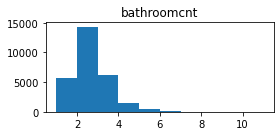

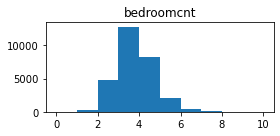

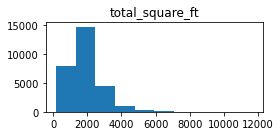

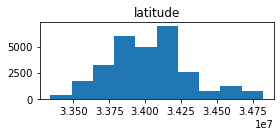

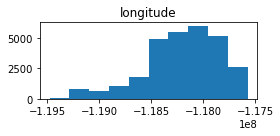

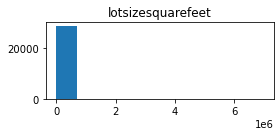

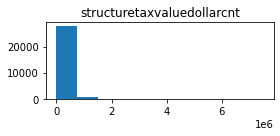

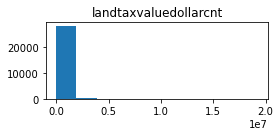

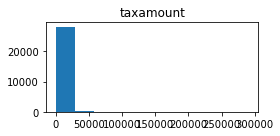

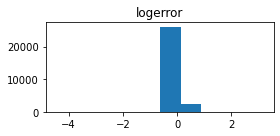

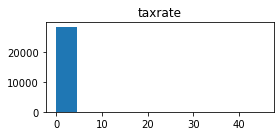

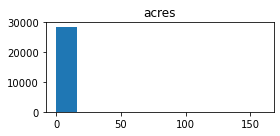

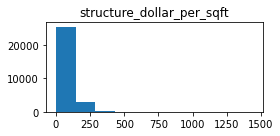

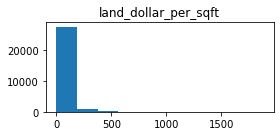

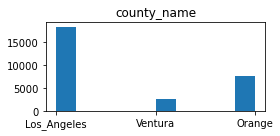

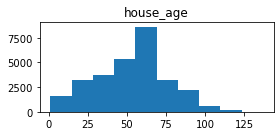

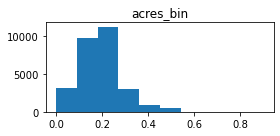

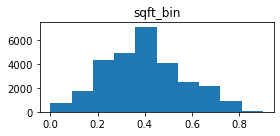

In [30]:
for col in train.columns:
    plt.figure(figsize=(4,2))
    plt.hist(train[col])
    plt.title(col)
    plt.tight_layout()
    plt.show()

### Univariate chart takeaways:
- Normal Distribution: house_age, logitude, latitude, bedroomcnt
- Categoricals : county_name, bedroomcnt, bathroomcnt.


<AxesSubplot:title={'center':'Feautures  Correlating with logerror'}>

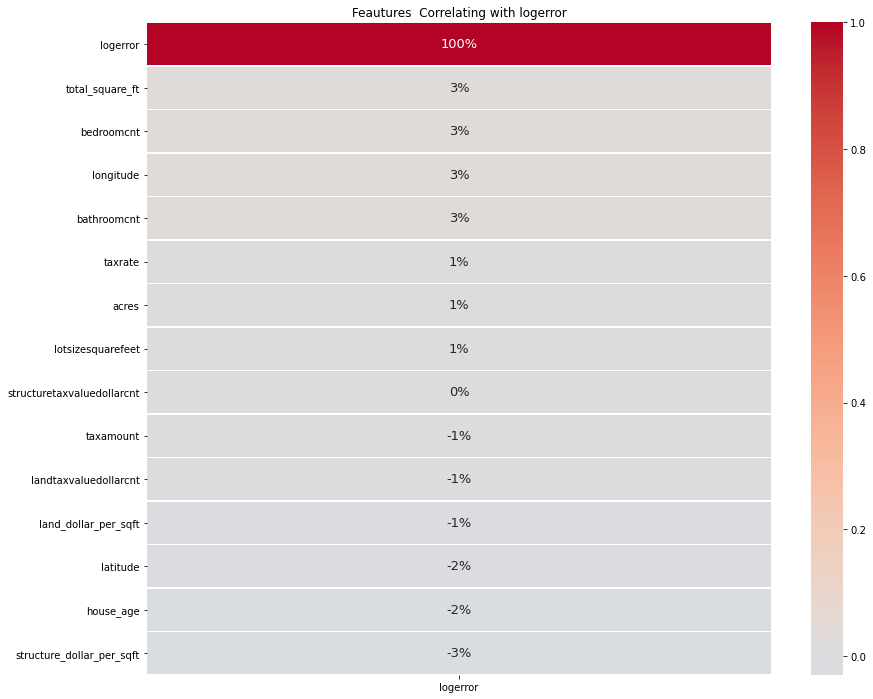

In [31]:
explore.get_heatmap(train,'logerror')

In [32]:
train.isna().sum()

bathroomcnt                   0
bedroomcnt                    0
total_square_ft               0
latitude                      0
longitude                     0
lotsizesquarefeet             0
structuretaxvaluedollarcnt    0
landtaxvaluedollarcnt         0
taxamount                     0
logerror                      0
taxrate                       0
acres                         0
structure_dollar_per_sqft     0
land_dollar_per_sqft          0
county_name                   0
house_age                     0
acres_bin                     0
sqft_bin                      0
dtype: int64

In [33]:
train.drop(columns = ['bathroomcnt','lotsizesquarefeet',
       'landtaxvaluedollarcnt', 'taxamount'], inplace = True)

In [34]:
validate.drop(columns = ['bathroomcnt','lotsizesquarefeet',
       'landtaxvaluedollarcnt', 'taxamount'], inplace = True)

In [35]:
test.drop(columns = ['bathroomcnt','lotsizesquarefeet',
       'landtaxvaluedollarcnt', 'taxamount'], inplace = True)

### Heatmap Takeaways:
- correlations are not the strongest but there is still some.

In [36]:
train['logerror_bin'] = pd.cut(train.logerror, [-5, -.2, -.05, .05, .2, 4])
train.head()

,bedroomcnt,total_square_ft,latitude,longitude,structuretaxvaluedollarcnt,logerror,taxrate,acres,structure_dollar_per_sqft,land_dollar_per_sqft,county_name,house_age,acres_bin,sqft_bin,logerror_bin
parcelid,,,,,,,,,,,,,,,
12917452,2.00,907,"34,095,309.00","-117,959,373.00",77773,0.03,1.34,0.14,85,23,Los_Angeles,67.00,0.10,0.10,"(-0.05, 0.05]"
11969551,2.00,761,"34,129,037.00","-118,217,030.00",52150,0.25,1.20,0.10,68,39,Los_Angeles,80.00,0.00,0.00,"(0.2, 4.0]"
10981554,2.00,1504,"34,278,743.00","-118,372,349.00",214100,-0.04,1.24,0.43,142,11,Los_Angeles,66.00,0.30,0.40,"(-0.05, 0.05]"
10734687,3.00,2018,"34,179,446.00","-118,648,071.00",80128,-0.10,1.35,0.21,39,3,Los_Angeles,57.00,0.20,0.50,"(-0.2, -0.05]"
17160412,2.00,2243,"34,206,280.00","-119,183,071.00",57942,0.16,1.15,0.19,25,2,Ventura,64.00,0.20,0.50,"(0.05, 0.2]"


In [37]:
# creating pairplot

sns.pairplot(data = train, hue = 'logerror_bin')

## PairPlot Takeaways:

Every feature has a section which contains a large spread for error so I would assume moving forward that these features will be useful in clustering.  

In [38]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
bedroomcnt,"28,588.00",3.30,0.93,0.00,3.00,3.00,4.00,10.00
total_square_ft,"28,588.00","1,904.88",961.84,152.00,"1,266.00","1,648.00","2,289.00","11,704.00"
latitude,"28,588.00","34,023,761.80","271,964.29","33,341,224.00","33,831,713.50","34,028,025.00","34,187,465.00","34,818,767.00"
longitude,"28,588.00","-118,199,652.80","361,378.32","-119,475,265.00","-118,399,262.75","-118,157,423.50","-117,930,674.50","-117,572,338.00"
structuretaxvaluedollarcnt,"28,588.00","191,885.50","233,676.05",302.00,"77,243.75","130,799.50","221,325.75","7,507,773.00"
logerror,"28,588.00",0.02,0.17,-4.45,-0.02,0.01,0.04,3.18
taxrate,"28,588.00",1.33,0.49,0.01,1.16,1.23,1.36,45.29
acres,"28,588.00",0.26,2.41,0.01,0.13,0.16,0.20,160.03
structure_dollar_per_sqft,"28,588.00",89.92,59.70,0.00,54.00,81.00,112.00,"1,444.00"
land_dollar_per_sqft,"28,588.00",48.00,72.07,0.00,9.00,30.00,60.00,"1,882.00"


----------

# Statistical Testing:

 Pearson correlation coefficient is -0.024596339334683, the corresponding p value is 3.19373951262468e-05.
 We reject the null, and accept HA, There is a relationship between logerror and house_age.


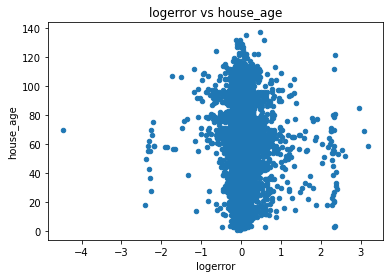

In [39]:
#Pearson Correlation

Null = 'There is no relationship between logerror and house_age'
HA = 'There is a relationship between logerror and house_age'
   
alpha = 0.05

corr, p = stats.pearsonr(train.house_age, train.logerror)
print(f' Pearson correlation coefficient is {corr}, the corresponding p value is {p}.')


train.plot.scatter('logerror', 'house_age')
plt.title('logerror vs house_age')

if p < 0.05:
    print(f' We reject the null, and accept HA, {HA}.')
else:
    print(f' We accept null, {Null}.')

 Pearson correlation coefficient is 0.03224491917128777, the corresponding p value is 4.9486403337048885e-08.
 We reject the null, and accept HA, There is a relationship between logerror and total_square_ft.


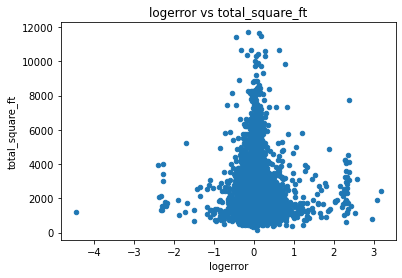

In [40]:
#Pearson Correlation

Null = 'There is no relationship between logerror and total_square_ft'
HA = 'There is a relationship between logerror and total_square_ft'
   
alpha = 0.05

corr, p = stats.pearsonr(train.total_square_ft, train.logerror)
print(f' Pearson correlation coefficient is {corr}, the corresponding p value is {p}.')


train.plot.scatter('logerror', 'total_square_ft')
plt.title('logerror vs total_square_ft')

if p < 0.05:
    print(f' We reject the null, and accept HA, {HA}.')
else:
    print(f' We accept null, {Null}.')

 Pearson correlation coefficient is -0.021696491576686155, the corresponding p value is 0.00024377624147329152.
 We reject the null, and accept HA, There is a relationship between logerror and latitude.


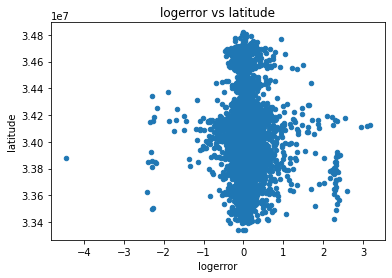

In [41]:
#Pearson Correlation

Null = 'There is no relationship between logerror and latitude'
HA = 'There is a relationship between logerror and latitude'
   
alpha = 0.05

corr, p = stats.pearsonr(train.latitude, train.logerror)
print(f' Pearson correlation coefficient is {corr}, the corresponding p value is {p}.')


train.plot.scatter('logerror', 'latitude')
plt.title('logerror vs latitude')

if p < 0.05:
    print(f' We reject the null, and accept HA, {HA}.')
else:
    print(f' We accept null, {Null}.')

In [42]:
#levene HO: equal variance across logerror between bedroomcount less than 3 and greater than 3.
stats.levene(train[train.bedroomcnt <= 3].logerror, train[train.bedroomcnt > 3].logerror)

LeveneResult(statistic=9.068097960249025, pvalue=0.002603346906183501)

In [43]:
#TTest 
# make a subset 
x1 = train[train.bedroomcnt <= 3].logerror
x2 = train[train.bedroomcnt > 3].logerror


# run a 2 sample, 2 tail t-test
t_stat, p = stats.ttest_ind(x1, x2)

print(f'\nstatistic = {t_stat:.4f}')
print(f'p_value = {p:.4f}')

# set alpha
alpha = 0.05

null_hypothesis = "There is no significant difference in the logerrors for those who have four or more bedrooms than those who dont."

if p < alpha:
    print(f'\nWe can reject the null hypothesis that', null_hypothesis)
else:
    print(f'\nWe fail to reject the null hypothesis.')


statistic = -4.6211
p_value = 0.0000

We can reject the null hypothesis that There is no significant difference in the logerrors for those who have four or more bedrooms than those who dont.


In [44]:
#levene HO: equal variance across logerror between total_square_ft <=2500 and greater than 2500.
stats.levene(train[train.total_square_ft <= 2500].logerror, train[train.total_square_ft > 2500].logerror)

LeveneResult(statistic=22.007395883013213, pvalue=2.7285736415288827e-06)

In [45]:
#TTest 
# make a subset 
x1 = train[train.total_square_ft <= 2500].logerror
x2 = train[train.total_square_ft > 2500].logerror


# run a 2 sample, 2 tail t-test
t_stat, p = stats.ttest_ind(x1, x2)

print(f'\nstatistic = {t_stat:.4f}')
print(f'p_value = {p:.4f}')

# set alpha
alpha = 0.05

null_hypothesis = "There is no significant difference in the logerrors for homes with less than 2500 sqrft than homes with greater than."

if p < alpha:
    print(f'\nWe can reject the null hypothesis that', null_hypothesis)
else:
    print(f'\nWe fail to reject the null hypothesis.')


statistic = -4.6947
p_value = 0.0000

We can reject the null hypothesis that There is no significant difference in the logerrors for homes with less than 2500 sqrft than homes with greater than.


In [46]:
#levene HO: equal variance across logerror between total_square_ft <=2500 and greater than 2500.
stats.levene(train[train.house_age <= 60].logerror, train[train.house_age > 60].logerror)

LeveneResult(statistic=146.52155830869222, pvalue=1.2069567650518182e-33)

In [47]:
#TTest 
# make a subset 
x1 = train[train.house_age <= 60].logerror
x2 = train[train.house_age > 60].logerror


# run a 2 sample, 2 tail t-test
t_stat, p = stats.ttest_ind(x1, x2)

print(f'\nstatistic = {t_stat:.4f}')
print(f'p_value = {p:.4f}')

# set alpha
alpha = 0.05

null_hypothesis = "There is no significant difference in the logerrors for homes greater than 60 years old than homes less than 60 years old"

if p < alpha:
    print(f'\nWe can reject the null hypothesis that', null_hypothesis)
else:
    print(f'\nWe fail to reject the null hypothesis.')


statistic = 4.4761
p_value = 0.0000

We can reject the null hypothesis that There is no significant difference in the logerrors for homes greater than 60 years old than homes less than 60 years old


----------

-----------------

# Exploration: Clustering

In [48]:
# this will be done on unscaled data!

### Work on unscaled!

In [49]:
from sklearn.preprocessing import StandardScaler

In [50]:
X = train[['latitude', 'longitude']]

In [51]:
scaler = StandardScaler().fit(X)
X_scaled = pd.DataFrame(scaler.transform(X), columns= X.columns).set_index([X.index.values])

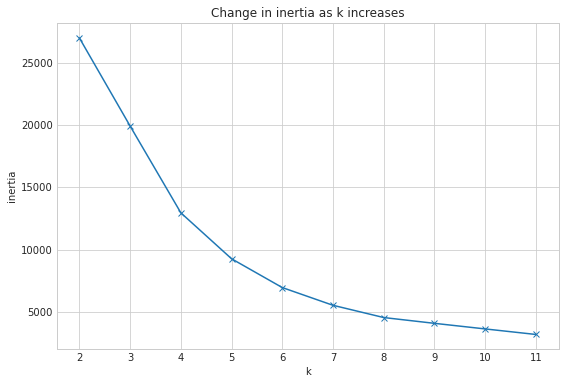

In [52]:
# use elbow method
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X_scaled).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')
    #drop of at 3

In [53]:
#Utilize the kmeans
kmeans = KMeans(n_clusters = 4)
kmeans.fit(X_scaled)
X_scaled['cluster'] = kmeans.predict(X_scaled)

In [54]:
centroids_scaled = pd.DataFrame(kmeans.cluster_centers_, columns=X_scaled.columns)
centroids_scaled

ValueError: Shape of passed values is (4, 2), indices imply (4, 3)

In [ ]:
plt.figure(figsize=(14, 9))

for cluster, subset in X_scaled.groupby('cluster'):
    plt.scatter(subset.latitude, subset.longitude, label='cluster ' + str(cluster), alpha=.6)

centroids_scaled.plot.scatter(x='latitude', y='longitude', c='black', marker='x', s=1000, ax=plt.gca(), label='centroid')

plt.legend()
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('Visualizing Cluster Centers')

-----------

---------

In [ ]:
X = train[['longitude', 'house_age']]

In [ ]:
scaler = StandardScaler().fit(X)
X1_scaled = pd.DataFrame(scaler.transform(X), columns= X.columns).set_index([X.index.values])

In [ ]:
# use elbow method
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X1_scaled).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')
    #drop of at 3

In [ ]:
#Utilize the kmeans
kmeans = KMeans(n_clusters =3)
kmeans.fit(X1_scaled)
X1_scaled['cluster'] = kmeans.predict(X1_scaled)

In [ ]:
centroids_scaled = pd.DataFrame(kmeans.cluster_centers_, columns=X1_scaled.columns)


In [ ]:
plt.figure(figsize=(14, 9))

for cluster, subset in X1_scaled.groupby('cluster'):
    plt.scatter(subset.longitude, subset.house_age, label='cluster ' + str(cluster), alpha=.6)

centroids_scaled.plot.scatter(x='longitude', y='house_age', c='black', marker='x', s=1000, ax=plt.gca(), label='centroid')

plt.legend()
plt.xlabel('longitude')
plt.ylabel('house_age')
plt.title('Visualizing Cluster Centers')

-------------

-----------

In [ ]:
#start w/ 2 features
X = train[['acres', 'house_age']]
X.head()

In [ ]:
scaler = StandardScaler().fit(X)
X3_scaled = pd.DataFrame(scaler.transform(X), columns= X.columns).set_index([X.index.values])

In [ ]:
X3_scaled.acres.max()

In [ ]:
# use elbow method
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X3_scaled).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')
    #drop of at 4

In [ ]:
kmeans = KMeans(n_clusters =4)
kmeans.fit(X3_scaled)
X3_scaled['cluster'] = kmeans.predict(X3_scaled)

In [ ]:
centroids_scaled = pd.DataFrame(kmeans.cluster_centers_, columns=X3_scaled.columns)
centroids_scaled

In [ ]:
plt.figure(figsize=(14, 9))

for cluster, subset in X3_scaled.groupby('cluster'):
    plt.scatter(subset.house_age, subset.acres, label='cluster ' + str(cluster), alpha=.6)
    plt.ylim(top = 1, bottom = -0.075)
    plt.xlim(left = -2.5, right = 3)

centroids_scaled.plot.scatter(x='house_age', y='acres', c='black', marker='x', s=1000, ax=plt.gca(), label='centroid')

plt.legend()
plt.xlabel('house_age')
plt.ylabel('acres')
plt.title('Visualizing Cluster Centers')

In [ ]:
X = train[['structuretaxvaluedollarcnt', 'house_age']]

In [ ]:
scaler = StandardScaler().fit(X)
X4_scaled = pd.DataFrame(scaler.transform(X), columns= X.columns).set_index([X.index.values])

In [ ]:
# use elbow method
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X4_scaled).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')
    

In [ ]:
kmeans = KMeans(n_clusters =5)
kmeans.fit(X4_scaled)
X4_scaled['cluster'] = kmeans.predict(X4_scaled)

In [ ]:
centroids_scaled = pd.DataFrame(kmeans.cluster_centers_, columns=X4_scaled.columns)
centroids_scaled

In [ ]:
plt.figure(figsize=(14, 9))

for cluster, subset in X4_scaled.groupby('cluster'):
    plt.scatter(subset.structuretaxvaluedollarcnt, subset.house_age, label='cluster ' + str(cluster), alpha=.6)
    plt.xlim(right = 4)
centroids_scaled.plot.scatter(x='structuretaxvaluedollarcnt', y='house_age', c='black', marker='x', s=1000, ax=plt.gca(), label='centroid')

plt.legend()
plt.xlabel('structuretaxvaluedollarcnt')
plt.ylabel('house_age')
plt.title('Visualizing Cluster Centers')

In [ ]:
X = train[['total_square_ft', 'house_age']]
scaler = StandardScaler().fit(X)
X5_scaled = pd.DataFrame(scaler.transform(X), columns= X.columns).set_index([X.index.values])

In [ ]:
# use elbow method
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X5_scaled).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

In [ ]:
kmeans = KMeans(n_clusters =6)
kmeans.fit(X5_scaled)
X5_scaled['cluster'] = kmeans.predict(X5_scaled)

In [ ]:
centroids_scaled = pd.DataFrame(kmeans.cluster_centers_, columns=X5_scaled.columns)
centroids_scaled

In [ ]:
plt.figure(figsize=(14, 9))

for cluster, subset in X5_scaled.groupby('cluster'):
    plt.scatter(subset.house_age, subset.total_square_ft, label='cluster ' + str(cluster), alpha=.6)
    plt.xlim(right = 3, left = -2.5)
    plt.ylim(top = 8)
centroids_scaled.plot.scatter(x= 'house_age', y='total_square_ft', c='black', marker='x', s=1000, ax=plt.gca(), label='centroid')


plt.legend()
plt.xlabel('structuretaxvaluedollarcnt')
plt.ylabel('house_age')
plt.title('Visualizing Cluster Centers')

In [ ]:
numeric_cols = ['house_age', 'total_square_ft', 'bedroomcnt', 'longitude', 'latitude', 'structuretaxvaluedollarcnt']
cols = ['house_age', 'total_square_ft', 'bedroomcnt', 'longitude', 'latitude', 'structuretaxvaluedollarcnt']
target = ['logerror']

In [ ]:
X_train, y_train = train[cols], train[target]
X_validate, y_validate = validate[cols], validate[target]
X_test, y_test = test[cols], test[target]

In [56]:
def create_cluster(df, X, k, col_name = None):
    """ Takes in df, X (dataframe with variables you want to cluster on) and k
    # It scales the X, calcuates the clusters and return train (with clusters), the Scaled dataframe,
    #the scaler and kmeans object and scaled centroids as a dataframe"""
    scaler = StandardScaler(copy=True).fit(X)
    X_scaled = pd.DataFrame(scaler.transform(X), columns=X.columns.values).set_index([X.index.values])
    kmeans = KMeans(n_clusters = k, random_state = 42)
    kmeans.fit(X_scaled)
    centroids_scaled = pd.DataFrame(kmeans.cluster_centers_, columns = list(X))
    if col_name == None:
        #clusters on dataframe 
        df[f'clusters_{k}'] = kmeans.predict(X_scaled)
    else:
        df[col_name] = kmeans.predict(X_scaled)
    return df, X_scaled, scaler, kmeans, centroids_scaled

In [57]:
X = train[['total_square_ft', 'house_age']]

In [58]:
train, X_scaled, scaler, kmeans, centroids = create_cluster(train, X, 6, 'age_size_cluster' )
train = train.astype({'age_size_cluster': 'category'})

In [59]:
tr_dummy_df = pd.get_dummies(train[['age_size_cluster']], dummy_na=False, drop_first=True)
train = pd.concat([train, tr_dummy_df], axis=1)

In [60]:
Xv = validate[['total_square_ft', 'house_age']]
validate, X_scaled, scaler, kmeans, centroids = create_cluster(validate, Xv, 6, 'age_size_cluster' )

In [61]:
validate = validate.astype({'age_size_cluster': 'category'})

In [62]:
val_dummy_df = pd.get_dummies(validate[['age_size_cluster']], dummy_na=False, drop_first=True)
validate = pd.concat([validate, val_dummy_df], axis=1)

In [63]:
Xt = test[['total_square_ft', 'house_age']]
test, X_scaled, scaler, kmeans, centroids = create_cluster(test, Xt, 6, 'age_size_cluster' )

In [64]:
test = test.astype({'age_size_cluster': 'category'})

In [65]:
test_dummy_df = pd.get_dummies(test[['age_size_cluster']], dummy_na=False, drop_first=True)
test = pd.concat([test, test_dummy_df], axis=1)

---------

## Statistical Testing: Clustering

### ANOVA

In [66]:
null_hypothesis = "log_error is the same across all 6 clusters"
alternative_hypothesis = "The log_error is different in the clusters"
alpha = 0.05 

In [67]:
train.age_size_cluster.value_counts()

1    11281
0     5848
3     3991
5     3404
4     3384
2      680
Name: age_size_cluster, dtype: int64

In [68]:
cluster0 = train[train.age_size_cluster == 0].logerror
cluster1 = train[train.age_size_cluster == 1].logerror
cluster2 = train[train.age_size_cluster == 2].logerror
cluster3 = train[train.age_size_cluster == 3].logerror
cluster4 = train[train.age_size_cluster == 4].logerror
cluster5 = train[train.age_size_cluster == 5].logerror

In [69]:
from scipy.stats import f_oneway

f, p = f_oneway(cluster0, cluster1, cluster2, cluster3, cluster4, cluster5)
round(f,4), round(p,14)

(8.1631, 1.0353572e-07)

In [70]:
if p < alpha:
    print("We reject the null hypothesis that", null_hypothesis)
    print("We move forward with the alternative hypothesis that", alternative_hypothesis)
else:
    print("We fail to reject the null hypothesis")
    

We reject the null hypothesis that log_error is the same across all 6 clusters
We move forward with the alternative hypothesis that The log_error is different in the clusters


-------------

### TTEST

In [71]:
null_hypothesis =  'is no difference in the means of the individual clusters logerrors to the population logerror mean.'
alternate_hypothesis = 'is a significant difference in the means of the clusters logerrors.'

In [72]:
clusters_pop_mean = (cluster0.mean() + cluster1.mean() + cluster2.mean() + cluster3.mean()+cluster4.mean() + cluster5.mean()/6)

In [73]:
# compare cluster0 to population
t0, p0 = stats.ttest_1samp(cluster0, clusters_pop_mean)
t0, p0

(-66.6886176276758, 0.0)

In [74]:
# compare cluster0 to population
t1, p1 = stats.ttest_1samp(cluster1, clusters_pop_mean)
t1, p1

(-66.6127183446623, 0.0)

In [75]:
# compare cluster0 to population
t2, p2 = stats.ttest_1samp(cluster2, clusters_pop_mean)
t2, p2

(-7.842892526841048, 1.710825203639061e-14)

In [76]:
# compare cluster0 to population
t3, p3 = stats.ttest_1samp(cluster3, clusters_pop_mean)
t3, p3

(-32.784663596697214, 5.901031075083808e-209)

In [77]:
# compare cluster0 to population
t4, p4 = stats.ttest_1samp(cluster4, clusters_pop_mean)
t4, p4

(-30.680760384025024, 1.3461010116373924e-182)

In [78]:
# compare cluster0 to population
t5, p5 = stats.ttest_1samp(cluster5, clusters_pop_mean)
t5, p5

(-30.103007902983478, 1.0299608612889582e-176)

In [79]:
if (p0 < alpha and p1 < alpha and p2 < alpha and p3 < alpha and p4 < alpha and p5 < alpha) :
    print("We reject the null hypothesis that", null_hypothesis)
    print("We move forward with the alternative hypothesis that", alternative_hypothesis)
else:
    print("We fail to reject the null hypothesis")
    

We reject the null hypothesis that is no difference in the means of the individual clusters logerrors to the population logerror mean.
We move forward with the alternative hypothesis that The log_error is different in the clusters


# Modeling:

In [80]:
cols = ['bedroomcnt', 'total_square_ft', 'latitude', 'longitude','house_age','age_size_cluster',
       'age_size_cluster_1', 'age_size_cluster_2', 'age_size_cluster_3','age_size_cluster_4', 'age_size_cluster_5']
target = 'logerror'

In [81]:
X_train, y_train = train[cols], train[target]
X_validate, y_validate = validate[cols], validate[target]
X_test, y_test = test[cols], test[target]

## Creating the baseline.

In [82]:
#Convert y_train and y_validate to dataframes to append the new columns with predicted values 
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

#Predict log_error_pred_mean
logerror_pred_mean = y_train['logerror'].mean()
y_train['logerror_pred_mean'] = logerror_pred_mean
y_validate['logerror_pred_mean'] = logerror_pred_mean

#Compute log_error_pred_median
logerror_pred_median = y_train['logerror'].median()
y_train['logerror_pred_median'] = logerror_pred_median
y_validate['logerror_pred_median'] = logerror_pred_median

In [83]:
#Evaluate the baseline model using the mean
#RMSE of log_error_pred_mean
baseline_RMSE = mean_squared_error(y_train.logerror, y_train.logerror_pred_mean) ** .5
baseline_val_RMSE = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_mean) ** .5

print("RMSE using Mean\nTrain/In-Sample: ", round(baseline_RMSE, 4),
      "\nValidate/Out-of-Sample: ", round(baseline_val_RMSE, 4))

#Evaluate the baseline model using the median
#RMSE of log_error_pred_mean
baseline_rmse_train_median = mean_squared_error(y_train.logerror, y_train.logerror_pred_median) ** .5
baseline_rmse_validate_median = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_median) ** .5

print("RMSE using Median\nTrain/In-Sample: ", round(baseline_rmse_train_median, 4), 
      "\nValidate/Out-of-Sample: ", round(baseline_rmse_validate_median, 4))

RMSE using Mean
Train/In-Sample:  0.173 
Validate/Out-of-Sample:  0.1655
RMSE using Median
Train/In-Sample:  0.1733 
Validate/Out-of-Sample:  0.1658


In [84]:
y_train

,logerror,logerror_pred_mean,logerror_pred_median
parcelid,,,
12917452,0.03,0.02,0.01
11969551,0.25,0.02,0.01
10981554,-0.04,0.02,0.01
10734687,-0.10,0.02,0.01
17160412,0.16,0.02,0.01
...,...,...,...
13998173,-0.03,0.02,0.01
17187951,-0.01,0.02,0.01
11284909,0.03,0.02,0.01


In [85]:
# using the mean for the baseline

### OLS Linear Regression Model

In [86]:
# create the model object
lm = LinearRegression(normalize=True)

# fit the model to our training data
lm.fit(X_train, y_train.logerror)

# predict train
y_train['logerror_pred_lm'] = lm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_lm) ** (1/2)


# predict validate
y_validate['logerror_pred_lm'] = lm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.logerror, y_validate.logerror_pred_lm) ** (1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate,
     "\nBaseline RMSE value is ", baseline_RMSE)
evs_lm = explained_variance_score(y_train.logerror, y_train.logerror_pred_lm)
print('Explained Variance Polynomial Model = ', round(evs_lm,3))

RMSE for OLS using LinearRegression
Training/In-Sample:  0.17273677810188087 
Validation/Out-of-Sample:  0.16588741523271863 
Baseline RMSE value is  0.17296116388246935
Explained Variance Polynomial Model =  0.003


### Polynomial Regression Model

In [97]:
# make the polynomial features to get a new set of features
poly_feat = PolynomialFeatures(degree=2)

# fit and transform X_train
X_train_degree2 = poly_feat.fit_transform(X_train)

# transform X_validate & X_test
X_validate_degree3 = poly_feat.transform(X_validate)
X_test_degree2 = poly_feat.transform(X_test)

y_test.shape, X_test.shape, X_test_degree2.shape

((10211, 2), (10211, 11), (10211, 78))

In [98]:
# create the model object
linear_model2 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
linear_model2.fit(X_train_degree2, y_train.logerror)

# predict train
y_train['logerror_predict_linear_model2'] = linear_model2.predict(X_train_degree2)

# evaluate: rmse
rmse_train_poly = mean_squared_error(y_train.logerror, y_train.logerror_predict_linear_model2)**(1/2)

# predict validate
y_validate['logerror_predict_linear_model2'] = linear_model2.predict(X_validate_degree3)

# evaluate: rmse
rmse_validate_poly = mean_squared_error(y_validate.logerror, y_validate.logerror_predict_linear_model2)**(1/2)

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train_poly, 
      "\nValidation/Out-of-Sample: ", rmse_validate_poly, 
      "\nBaseline RMSE value is ", baseline_RMSE)
evs_poly = explained_variance_score(y_train.logerror, y_train.logerror_predict_linear_model2)
print('Explained Variance Polynomial Model = ', round(evs_poly,3))

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  0.17249338141878068 
Validation/Out-of-Sample:  0.169211662803849 
Baseline RMSE value is  0.17296116388246935
Explained Variance Polynomial Model =  0.005


## Lasso Lars

In [93]:
# create the model object
lars_model = LassoLars(alpha=1.0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lars_model.fit(X_train, y_train.logerror)

# predict train
y_train['logerror_prediction_lars'] = lars_model.predict(X_train)

# evaluate: rmse
rmse_train_lars = mean_squared_error(y_train.logerror, y_train.logerror_prediction_lars)**(1/2)

# predict validate
y_validate['logerror_prediction_lars'] = lars_model.predict(X_validate)

# evaluate: rmse
rmse_validate_lars = mean_squared_error(y_validate.logerror, y_validate.logerror_prediction_lars)**(1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train_lars, 
      "\nValidation/Out-of-Sample: ", rmse_validate_lars,
      "\nBaseline RMSE value is ", baseline_RMSE)
evs_lars = explained_variance_score(y_train.logerror, y_train.logerror_prediction_lars)
print('Explained Variance Linear Regression Model = ', round(evs_lars,3))

RMSE for Lasso + Lars
Training/In-Sample:  0.17296116388246935 
Validation/Out-of-Sample:  0.1655498997292768 
Baseline RMSE value is  0.17296116388246935
Explained Variance Linear Regression Model =  0.0


## Tweedie Regressor

In [94]:
# create the model object
glm = TweedieRegressor(alpha=0)

# fit the model to our training data. 
glm.fit(X_train, y_train.logerror)


# predict train
y_train['logerror_pred_glm'] = glm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.logerror, y_train.logerror_pred_glm) ** (1/2)


# predict validate
y_validate['logerror_pred_glm'] = glm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_train.logerror, y_train.logerror_pred_glm) ** (1/2)

print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate,
     "\nBaseline RMSE value is ", baseline_RMSE)
evs_glm = explained_variance_score(y_train.logerror, y_train.logerror_pred_glm)
print('Explained Variance Linear Regression Model = ', round(evs_glm,3))

RMSE for GLM using Tweedie, power=1 & alpha=0
Training/In-Sample:  0.17294917151940953 
Validation/Out-of-Sample:  0.17294917151940953 
Baseline RMSE value is  0.17296116388246935
Explained Variance Linear Regression Model =  0.0


-------------------

## Evaluate on Test

In [99]:
# create the model object
# predict train
# create dataframe
y_test = pd.DataFrame(y_test)

# predict train
y_test['logerror_pred_poly'] = linear_model2.predict(X_test_degree2)

# evaluate: rmse
rmse_test = mean_squared_error(y_test.logerror, y_test.logerror_pred_poly) ** (1/2)


print("\nTest/Out-of-Sample: ", rmse_test,
      "\nBaseline RMSE value is ", baseline_RMSE)
evs_test = explained_variance_score(y_test.logerror, y_test.logerror_pred_poly)
print('Explained Variance Polynomial Model = ', round(evs_test,3))


Test/Out-of-Sample:  0.18954264614507177 
Baseline RMSE value is  0.17296116388246935
Explained Variance Polynomial Model =  -0.002


## Conclusion

Polynomial Regression was the best performing model, RMSE validate = 17.

The model performed worse than the baseline.




With more time:
- would like to find if there are better predictors of log error.
- would like to explore 3-D clustering by adding latitude or acres.
- would like to fill out the missing data so that there are even more data points to work with.